# Advanced Lane Lines

At the end of this project we will have working code that can detect lane lines more accurately than ever before.

## 1. Import necessary libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline


## 2. Calibrate Camera

In [2]:
cal_images = glob.glob('camera_cal/calibration*.jpg')
# plt.imshow(img)

In [3]:
objpoints = []
imgpoints = []

#prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

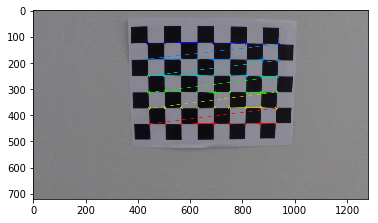

In [4]:
#load all calibration images

for fname in cal_images:
    img = mpimg.imread(fname)

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # plt.imshow(gray, cmap='gray')
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # print(ret,corners)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        img_corners = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img_corners)

## 3. Undistort test image

In [5]:
#Camera calibration, given object points, image points, and the shape of the grayscale image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

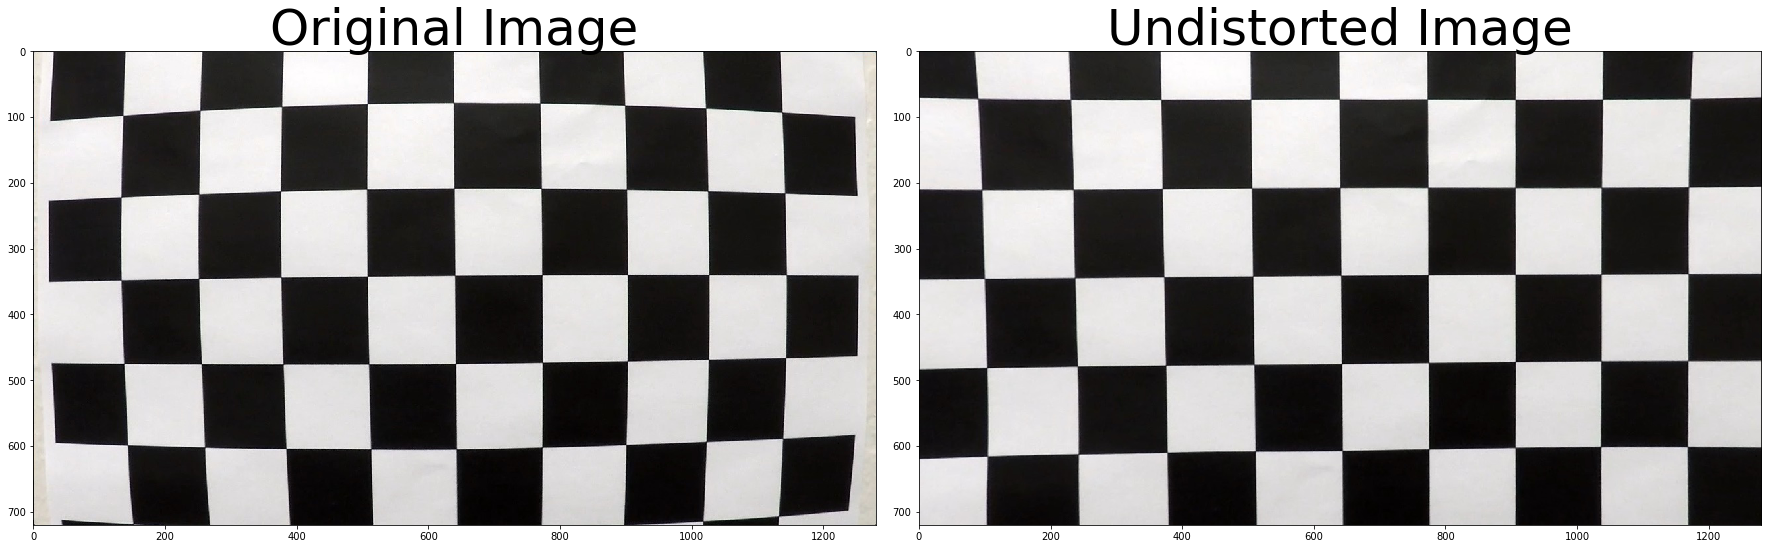

In [6]:
#undistort test image
test_img = mpimg.imread('camera_cal/calibration1.jpg')
# test_img = mpimg.imread('test_images/test1.jpg')
dst = cv2.undistort(test_img, mtx, dist, None, mtx)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [7]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

## 4. Perspective Transform Test Image

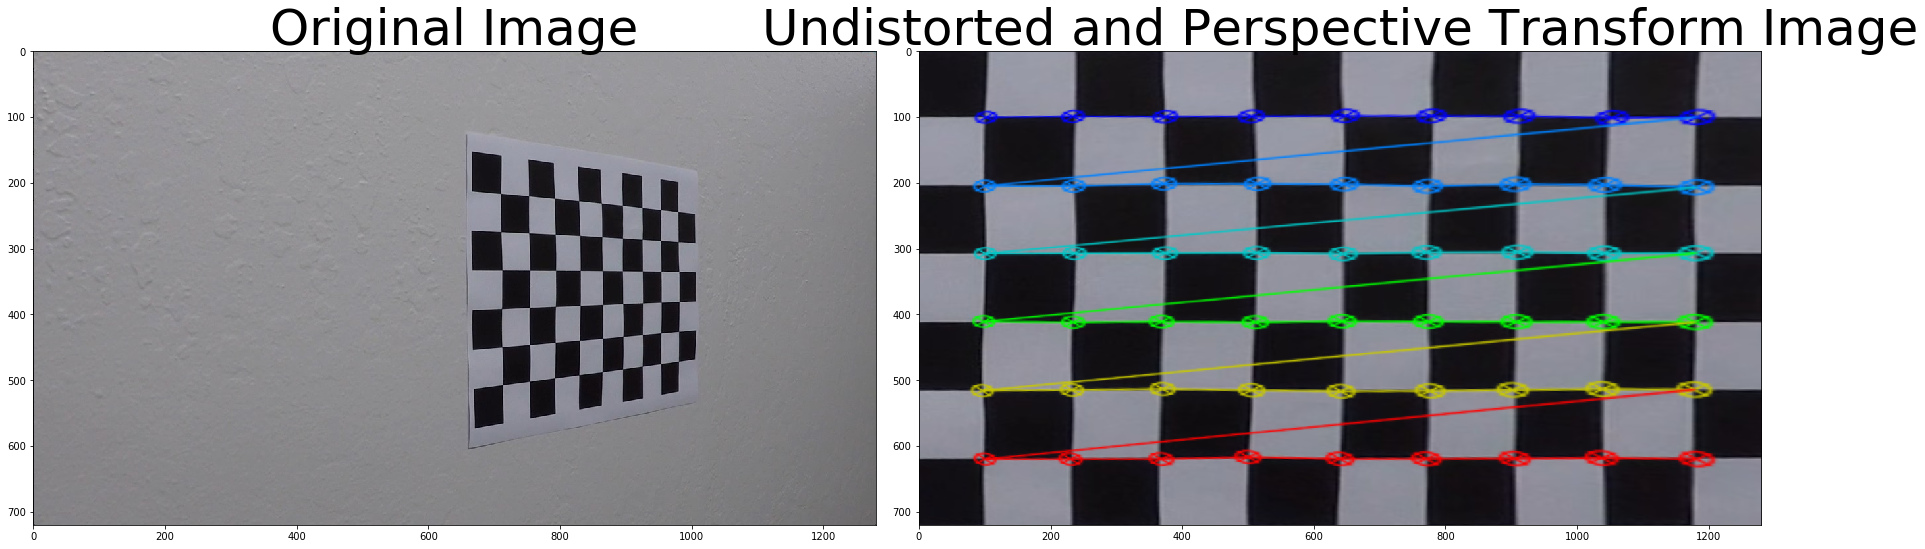

In [8]:
#undistort and warp test image
test_img = mpimg.imread('camera_cal/calibration8.jpg')
# test_img = mpimg.imread('test_images/test1.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

top_down, perspective_M = corners_unwarp(test_img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Perspective Transform Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 5. Create Image Binary

In [9]:
#pipeline for color & gradient threshold
#def pipeline(img, s_thresh=(140, 00), sx_thresh=(17, 100)):
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    
    return combined_binary

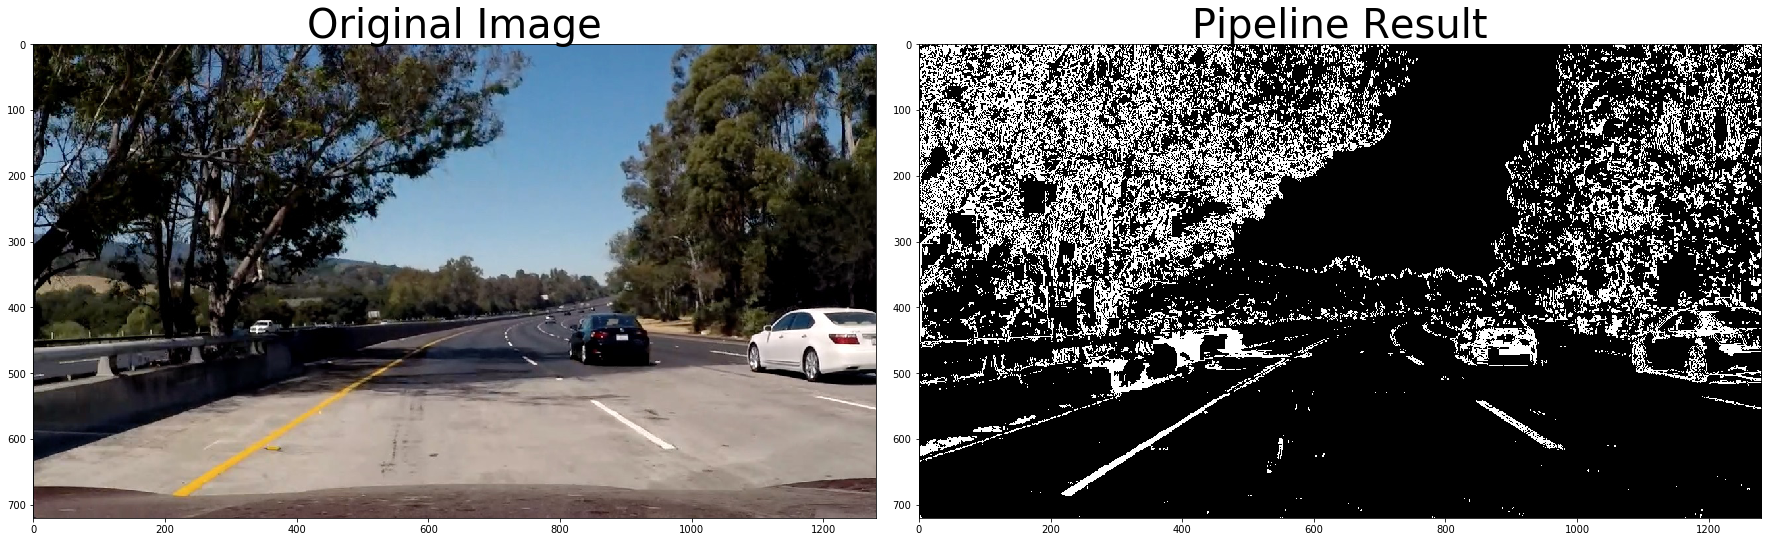

In [10]:
#color & gradient threshold test image

# test_img = mpimg.imread('camera_cal/calibration8.jpg')
test_img = mpimg.imread('test_images/test5.jpg')
result = pipeline(test_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 6. Create Bird's Eye Pipeline

In [11]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients

#hard coded src and dest points for birds eye
# src = np.float32([[240,680],[579,450],[700,450],[1050,670]])
# dst =  np.float32([[300,719],[225,0],[850,0],[800,719]])
img_size = (test_img.shape[1], test_img.shape[0])
xff1 = 60 # as copied, this was 55
xff2 = 60 # as copied, this was 60
yff = 95 # as copied, this was 100
src = np.float32(
    [[(img_size[0] / 2) - xff1, img_size[1] / 2 + yff],
     [((img_size[0] / 6) - xff2), img_size[1]],
     [(img_size[0] * 5 / 6) + xff2, img_size[1]],
     [(img_size[0] / 2 + xff1), img_size[1] / 2 + yff]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

Minv = cv2.getPerspectiveTransform(dst, src)

def road_pers_transform(img, src, dst, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
#     gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)

    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

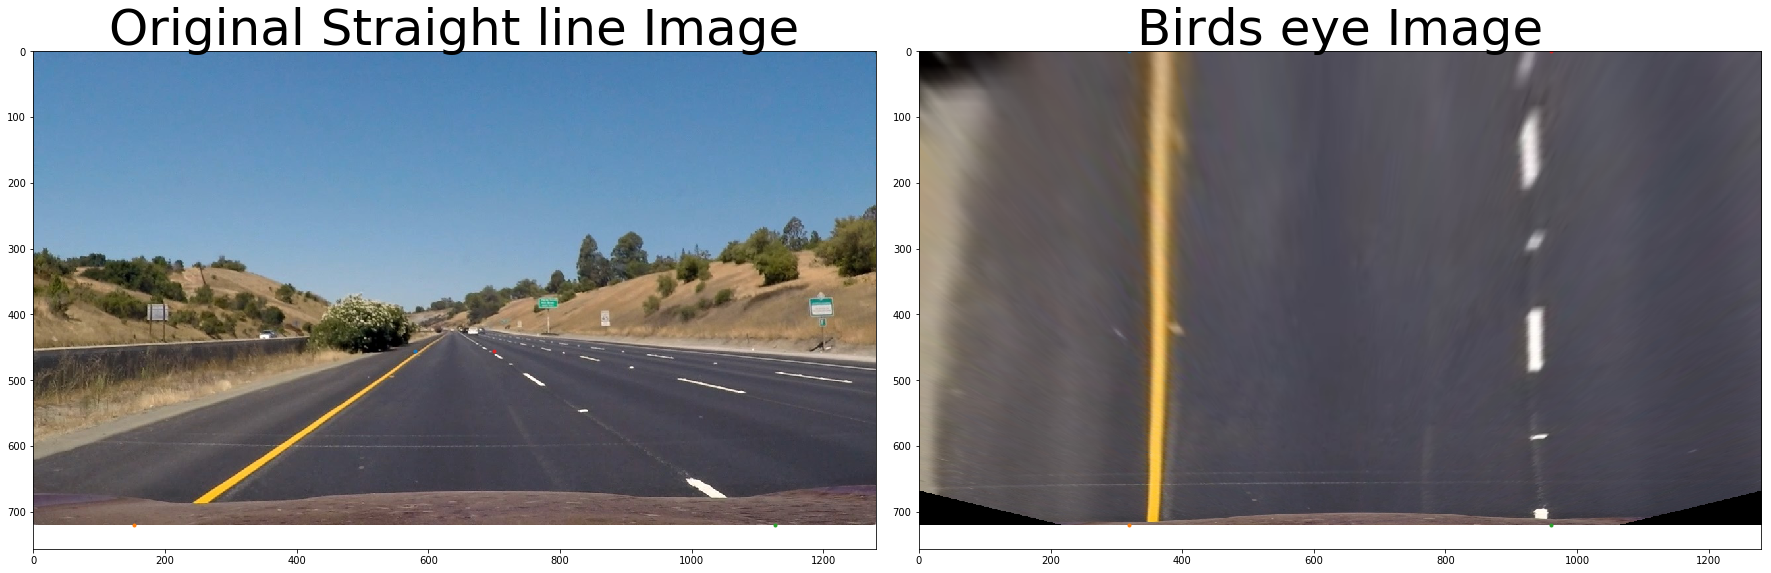

In [12]:
#undistort and warp test road image

test_img = mpimg.imread('test_images/straight_lines1.jpg')

top_down, perspective_M = road_pers_transform(test_img, src, dst, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.plot(src[0][0],src[0][1],'.')
ax1.plot(src[1][0],src[1][1],'.')
ax1.plot(src[2][0],src[2][1],'.')
ax1.plot(src[3][0],src[3][1],'.')

ax1.set_title('Original Straight line Image', fontsize=50)
ax2.imshow(top_down)
ax2.plot(dst[0][0],dst[0][1],'.')
ax2.plot(dst[1][0],dst[1][1],'.')
ax2.plot(dst[2][0],dst[2][1],'.')
ax2.plot(dst[3][0],dst[3][1],'.')

ax2.set_title('Birds eye Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

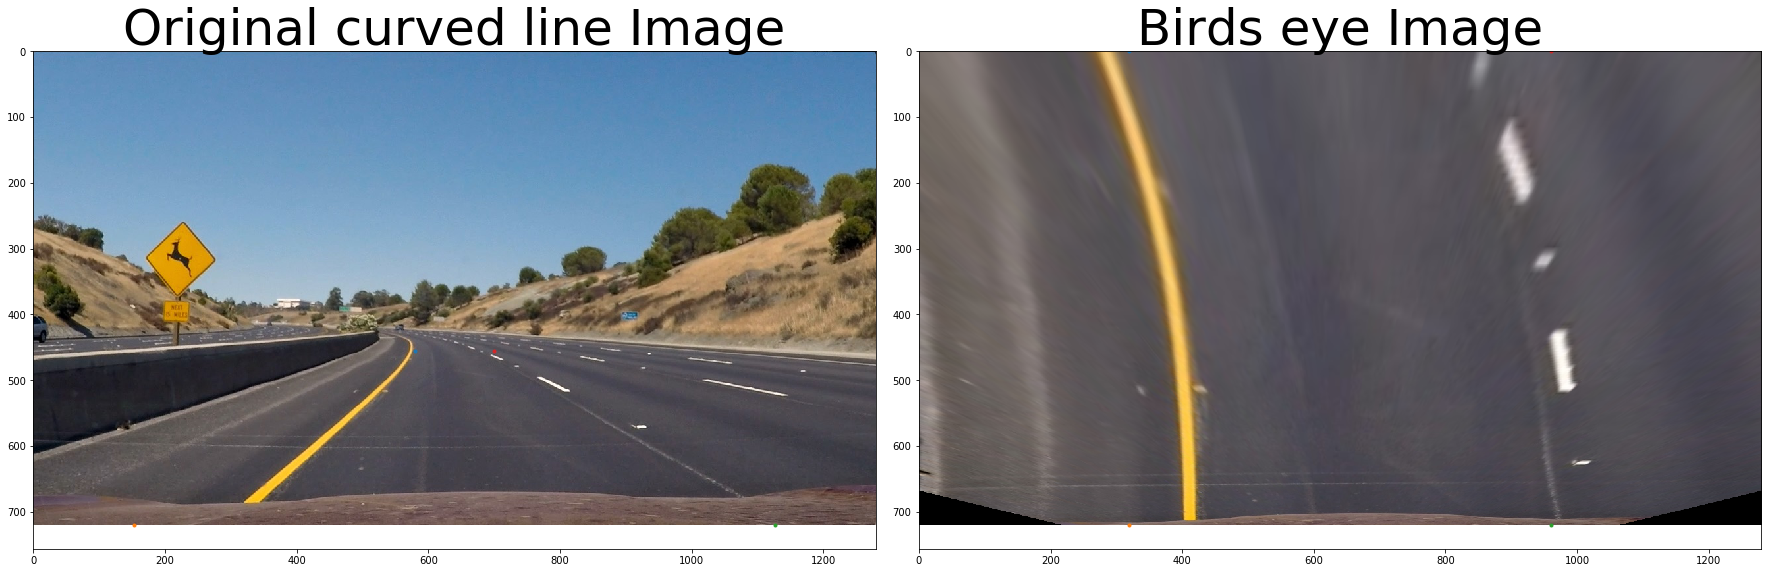

In [13]:
#undistort and warp test road image

test_img = mpimg.imread('test_images/test2.jpg')

top_down, perspective_M = road_pers_transform(test_img, src, dst, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.plot(src[0][0],src[0][1],'.')
ax1.plot(src[1][0],src[1][1],'.')
ax1.plot(src[2][0],src[2][1],'.')
ax1.plot(src[3][0],src[3][1],'.')

ax1.set_title('Original curved line Image', fontsize=50)
ax2.imshow(top_down)
ax2.plot(dst[0][0],dst[0][1],'.')
ax2.plot(dst[1][0],dst[1][1],'.')
ax2.plot(dst[2][0],dst[2][1],'.')
ax2.plot(dst[3][0],dst[3][1],'.')

ax2.set_title('Birds eye Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 7. Combine Binary and Bird's Eye

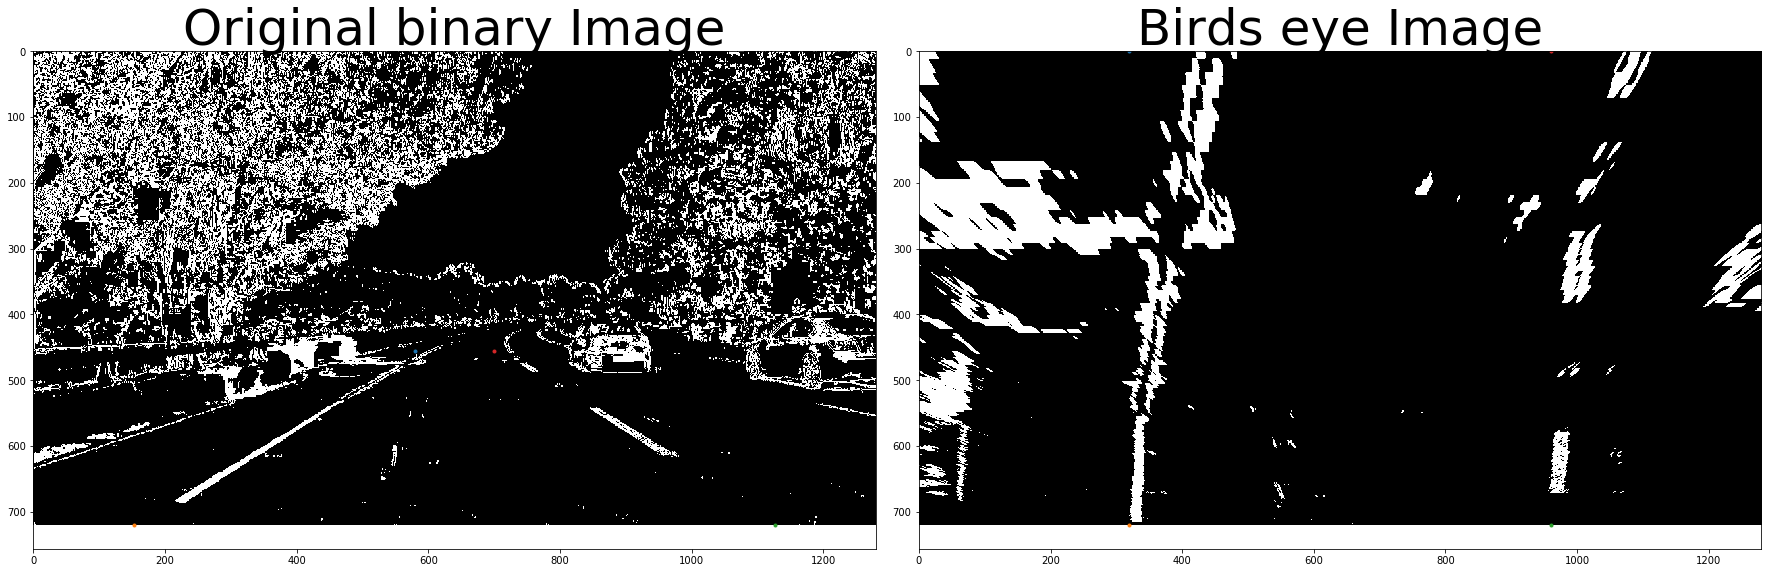

In [14]:
#undistort and warp test road image

test_img = mpimg.imread('test_images/test5.jpg')
result = pipeline(test_img)

top_down, perspective_M = road_pers_transform(result, src, dst, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(result, cmap='gray')
ax1.plot(src[0][0],src[0][1],'.')
ax1.plot(src[1][0],src[1][1],'.')
ax1.plot(src[2][0],src[2][1],'.')
ax1.plot(src[3][0],src[3][1],'.')

ax1.set_title('Original binary Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.plot(dst[0][0],dst[0][1],'.')
ax2.plot(dst[1][0],dst[1][1],'.')
ax2.plot(dst[2][0],dst[2][1],'.')
ax2.plot(dst[3][0],dst[3][1],'.')

ax2.set_title('Birds eye Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 8. Basic Line Finding

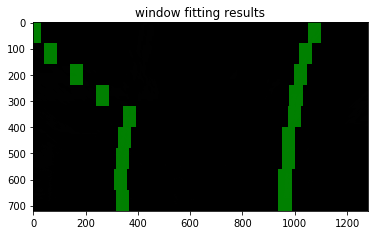

In [15]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(top_down[int(3*top_down.shape[0]/4):,:int(top_down.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(top_down[int(3*top_down.shape[0]/4):,int(top_down.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(top_down.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(top_down.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(top_down[int(top_down.shape[0]-(level+1)*window_height):int(top_down.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,top_down.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,top_down.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(top_down, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(top_down)
    r_points = np.zeros_like(top_down)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,top_down,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,top_down,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((top_down,top_down,top_down)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
    # If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((top_down,top_down,top_down)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

In [16]:
print(len(window_centroids))
print(window_centroids[0])

9
(343.0, 963.0)


## 9. Advanced Line Finding

In [17]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
# binary_warped = top_down
def binary_lane_lines(binary_warped, left_fit=None, right_fit=None):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    
    if left_fit == None and right_fit == None:
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    else:
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm', left_curverad - right_curverad, 'diff', left_fit[0]-right_fit[0])
    # Example values: 632.1 m    626.2 m
    
    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy



(720, 0)

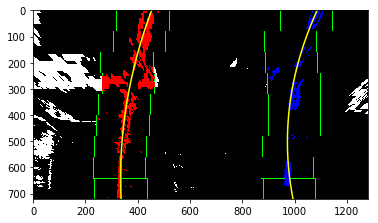

In [18]:
out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = binary_lane_lines(top_down)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


(720, 0)

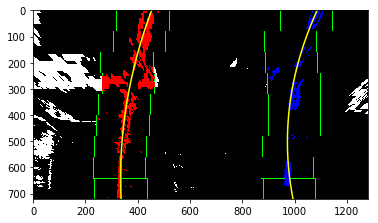

In [19]:
out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = binary_lane_lines(top_down)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


## 10. Look Ahead Filter

In [20]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def look_ahead_filter(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm', (left_curverad + right_curverad)/2, 'diff', left_fit[0]-right_fit[0])
    # Example values: 632.1 m    626.2 m
    
    return out_img, window_img, left_line_pts, right_line_pts


In [22]:
out_img, window_img, left_line_pts, right_line_pts = look_ahead_filter(top_down, left_fit, right_fit)

350.986332749
985.957809439
offset 0.103549431171


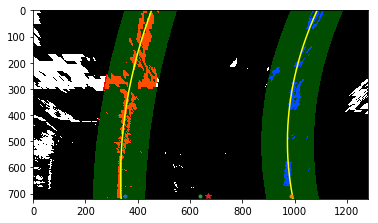

In [23]:

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
print(left_line_pts[0][0][0])
print(right_line_pts[0][0][0])

t_lane = [left_line_pts[0][0][0], right_line_pts[0][0][0]]
t_lane_size = t_lane[1] - t_lane[0]
plt.plot(t_lane[0],710,'.')
plt.plot(t_lane[1],710,'.')
plt.plot(640,710,'.')
plt.plot(t_lane[0] + t_lane_size//2,710,'*')
print('offset',((t_lane[0] + t_lane_size//2) - 640)*3.7/1000)

### Look ahead testing

In [24]:
#18 good, 19 bad

# good_img = mpimg.imread('output_images/average_test19.jpg')
# good_r = process_image(good_img)

# bad_img = mpimg.imread('output_images/average_test18.jpg')
# bad_r = process_image(bad_img)

# top_down, perspective_M = road_pers_transform(result, src, dst, mtx, dist)



good_img = mpimg.imread('output_images/average_test18.jpg')
good_r = pipeline(good_img)

good_top_down, perspective_M = road_pers_transform(good_r, src, dst, mtx, dist)

bad_img = mpimg.imread('output_images/average_test19.jpg')
bad_r = pipeline(bad_img)

bad_top_down, perspective_M = road_pers_transform(bad_r, src, dst, mtx, dist)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
# ax1.imshow(good_top_down, cmap='gray')
ax1.set_title('Good 18', fontsize=50)

# ax2.imshow(bad_top_down, cmap='gray')
ax2.set_title('Bad 19', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax3.set_title('Bad fixed', fontsize=50)

out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = binary_lane_lines(bad_top_down)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')

out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = binary_lane_lines(good_top_down)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
ax1.imshow(out_img)
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')

out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = binary_lane_lines(bad_top_down,left_fit, right_fit)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
ax3.imshow(out_img)
ax3.plot(left_fitx, ploty, color='yellow')
ax3.plot(right_fitx, ploty, color='yellow')

FileNotFoundError: [Errno 2] No such file or directory: 'output_images/average_test18.jpg'

## 11. Project Onto Road

In [25]:
# Create an image to draw the lines on
# warped = top_down
image = test_img
def project_lane_lines(image, warped, ploty, left_fitx, right_fitx, dst, src):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result


350.986332749
985.957809439


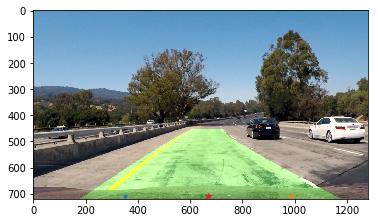

In [64]:
result = project_lane_lines(t_img, top_down, ploty, left_fitx, right_fitx, dst, src)
plt.imshow(result)
# plt.plot(250,720,'.')
# plt.plot(1150,720,'.')
# plt.plot(640,720,'.')
# plt.plot(250+450,720,'*')
# print((((250+450)-640)*4.1)/1000)


print(left_line_pts[0][0][0])
print(right_line_pts[0][0][0])
t_lane = [left_line_pts[0][0][0], right_line_pts[0][0][0]]
t_lane_size = t_lane[1] - t_lane[0]
plt.plot(t_lane[0],710,'.')
plt.plot(t_lane[1],710,'.')
plt.plot(640,710,'.')
plt.plot(t_lane[0] + t_lane_size//2,710,'*')
# cv2.circle(result,(447,63), 63, (0,0,255), -1)


## 12. Full Pipeline

In [108]:
def lane_line_pipeline(img, src, dst, mtx, dist, left_fit=None, right_fit=None):
    # run binary pipeline
    result = pipeline(img)
    
    # get birds eye and perspective matrix
    top_down, perspective_M = road_pers_transform(result, src, dst, mtx, dist)
    
    out_img, ploty, left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = binary_lane_lines(top_down, left_fit, right_fit)
    
    out_img, window_img, left_line_pts, right_line_pts = look_ahead_filter(top_down, left_fit, right_fit)
    
    result = project_lane_lines(img, top_down, ploty, left_fitx, right_fitx, dst, src)
    
    return result, left_fit, right_fit

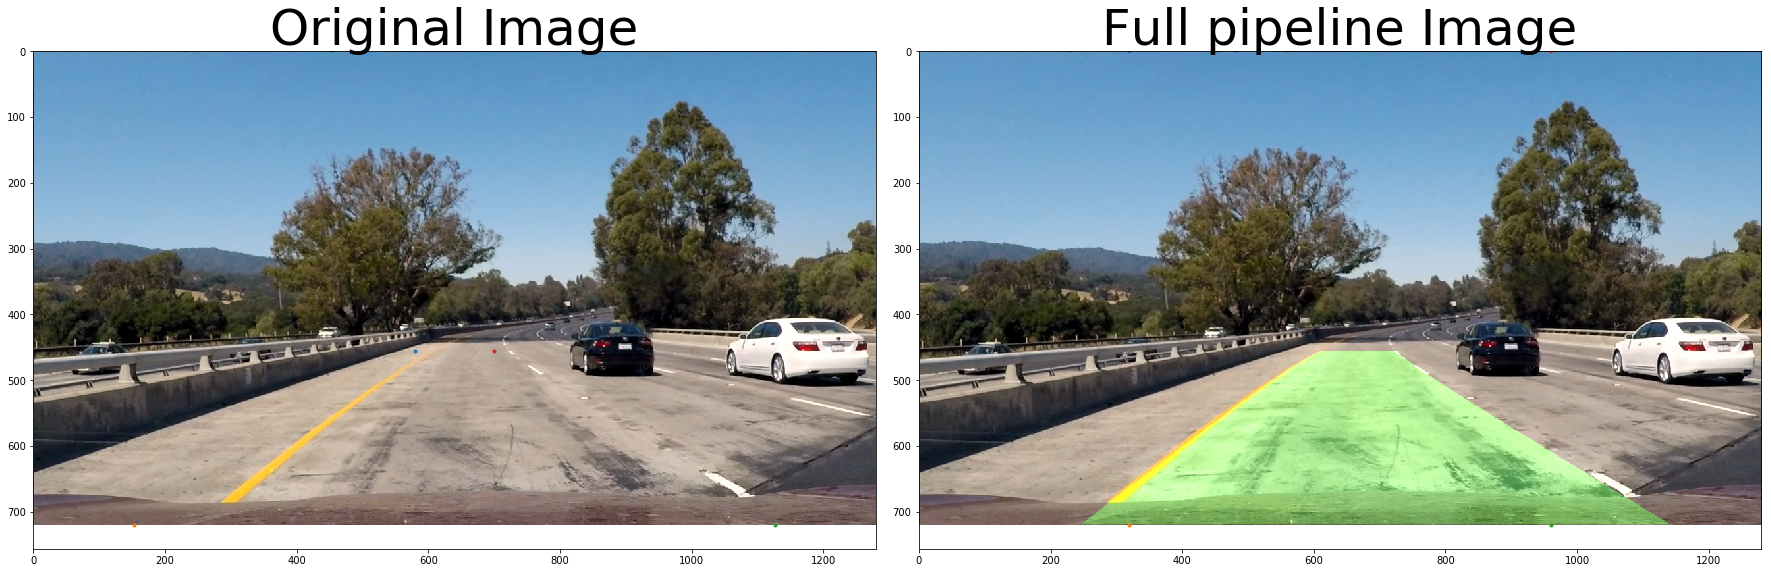

In [82]:
# run full pipeline on test images

t_img = mpimg.imread('test_images/test1.jpg')
result,l,r = lane_line_pipeline(t_img, src, dst, mtx, dist)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(t_img)
ax1.plot(src[0][0],src[0][1],'.')
ax1.plot(src[1][0],src[1][1],'.')
ax1.plot(src[2][0],src[2][1],'.')
ax1.plot(src[3][0],src[3][1],'.')

ax1.set_title('Original Image', fontsize=50)
ax2.imshow(result)
ax2.plot(dst[0][0],dst[0][1],'.')
ax2.plot(dst[1][0],dst[1][1],'.')
ax2.plot(dst[2][0],dst[2][1],'.')
ax2.plot(dst[3][0],dst[3][1],'.')

ax2.set_title('Full pipeline Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [29]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [102]:
font = cv2.FONT_HERSHEY_SIMPLEX
i = 1
vid_left_fit = None
vid_right_fit = None
def process_image(image):
    global i, vid_left_fit, vid_right_fit
    result, vid_left_fit, vid_right_fit = lane_line_pipeline(image, src, dst, mtx, dist, vid_left_fit, vid_right_fit)
#     result, vid_left_fit, vid_right_fit = lane_line_pipeline(image, src, dst, mtx, dist)
    
    average_image = ImageClip(image)
        
    #saving the image and loading it because it wasn't working as is
    average_image.save_frame("output_images/average_test{}.jpg".format(i))
#     average_image_file = mpimg.imread('output_images/average_test{}.jpg'.format(i))
    
    result_image = ImageClip(result)
        
    #saving the image and loading it because it wasn't working as is
    result_image.save_frame("output_images/result_test{}.jpg".format(i))
#     result_image = mpimg.imread('output_images/result_test{}.jpg'.format(i))
    i+=1
    
    #put text on image
    cv2.putText(result,'Hello World!',(10,50), font, 1,(255,255,255),2)
    cv2.putText(result,'{}'.format(i),(10,80), font, 1,(255,255,255),2)
    
    t_lane = [left_line_pts[0][0][0], right_line_pts[0][0][0]]
    t_lane_size = t_lane[1] - t_lane[0]
    
    cv2.putText(result,'L',(int(t_lane[0]),710), font, 1,(255,255,255),2)
#     plt.plot(t_lane[0],710,'.')
    cv2.putText(result,'R',(int(t_lane[1]),710), font, 1,(255,255,255),2)
#     plt.plot(t_lane[1],710,'.')
    cv2.putText(result,'C',(640,710), font, 1,(255,255,255),2)
#     plt.plot(640,710,'.')
#     plt.plot(t_lane[0] + t_lane_size//2,710,'*')
    cur = t_lane[0] + t_lane_size//2
#     print(cur)
    cv2.putText(result,'*',(int(cur),710), font, 1,(255,0,0),2)
    
    return result

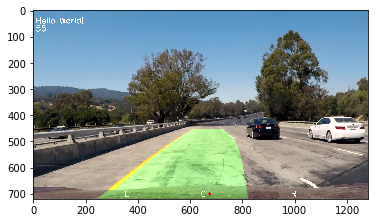

In [110]:
# image = None
t_img = mpimg.imread('test_images/test1.jpg')
r = process_image(t_img)
# print(r[0][0])
plt.imshow(r)

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip, ImageClip, ImageSequenceClip
from IPython.display import HTML

In [112]:
avg_image_array = []
test_output = 'test_videos_output/1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
# clip1 = VideoFileClip("project_video.mp4").subclip(22,23)
# clip1 = VideoFileClip("project_video.mp4").subclip(41,42)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/1.mp4
[MoviePy] Writing video test_videos_output/1.mp4


100%|█████████▉| 1260/1261 [04:46<00:00,  4.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/1.mp4 

CPU times: user 7min 12s, sys: 27 s, total: 7min 39s
Wall time: 4min 47s


In [60]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

In [37]:
avg_image_array = []
test_output_hard = 'test_videos_output/2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,1)
# clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(test_output_hard, audio=False)

[MoviePy] >>>> Building video test_videos_output/2.mp4
[MoviePy] Writing video test_videos_output/2.mp4


 96%|█████████▌| 25/26 [00:05<00:00,  4.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/2.mp4 

CPU times: user 8.25 s, sys: 1.03 s, total: 9.28 s
Wall time: 6.02 s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output_hard))